In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d phylake1337/fire-dataset

Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0
100% 386M/387M [00:03<00:00, 104MB/s] 
100% 387M/387M [00:03<00:00, 124MB/s]


In [5]:

import zipfile
zip_ref = zipfile.ZipFile('/content/fire-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

In [7]:
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [8]:
from pathlib import Path
import os.path

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [10]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-06-14 06:26:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-14 06:26:35 (99.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [12]:
dataset = "/content/fire_dataset"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/fire_dataset'.
There are 0 directories and 244 images in '/content/fire_dataset/non_fire_images'.
There are 0 directories and 755 images in '/content/fire_dataset/fire_images'.


In [13]:
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [14]:
print('Length of our data set : ' , len(list(image_dir.glob(r'**/*.png'))))
print('Labels : ' , labels )

Length of our data set :  999
Labels :  0      non_fire_images
1      non_fire_images
2      non_fire_images
3      non_fire_images
4      non_fire_images
            ...       
994        fire_images
995        fire_images
996        fire_images
997        fire_images
998        fire_images
Name: Label, Length: 999, dtype: object


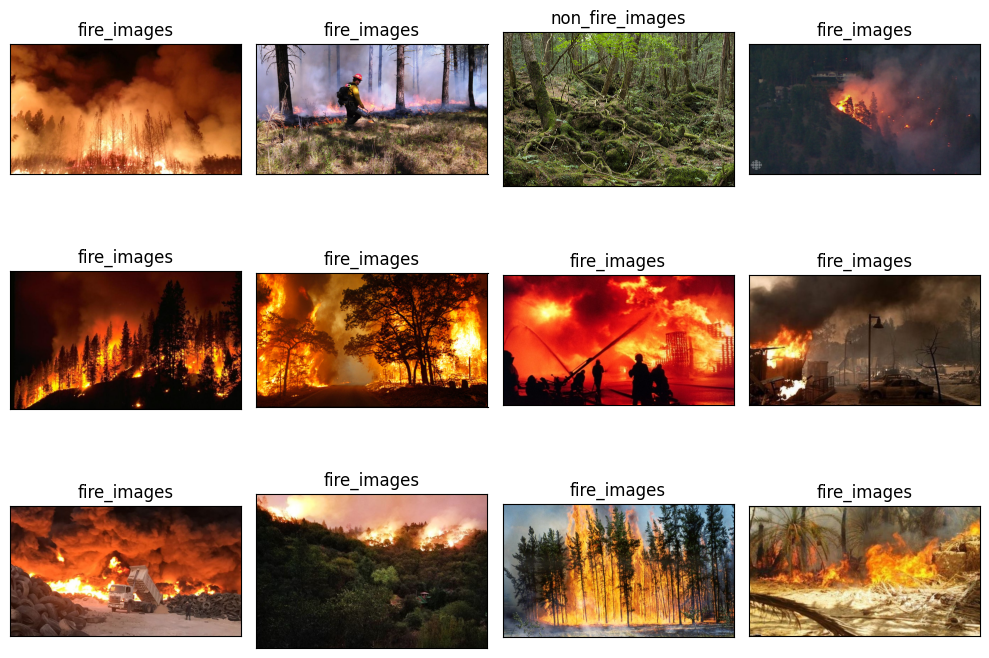

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


random_indices = np.random.randint(0, len(image_df), 12)


fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7.5),
                         subplot_kw={'xticks': [], 'yticks': []})

axes = axes.flatten()

for i, ax in enumerate(axes):

    image = Image.open(image_df.Filepath[random_indices[i]])

    ax.imshow(image)

    ax.set_title(image_df.Label[random_indices[i]])

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

plt.show()

In [16]:
train, test = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [18]:
train

,Filepath,Label
778,/content/fire_dataset/fire_images/fire.700.png,fire_images
286,/content/fire_dataset/fire_images/fire.688.png,fire_images
165,/content/fire_dataset/non_fire_images/non_fire...,non_fire_images
960,/content/fire_dataset/fire_images/fire.88.png,fire_images
493,/content/fire_dataset/fire_images/fire.404.png,fire_images
...,...,...
106,/content/fire_dataset/non_fire_images/non_fire...,non_fire_images
270,/content/fire_dataset/fire_images/fire.564.png,fire_images
860,/content/fire_dataset/fire_images/fire.58.png,fire_images
435,/content/fire_dataset/fire_images/fire.324.png,fire_images


In [17]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [20]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)


Found 640 validated image filenames belonging to 2 classes.


In [21]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 159 validated image filenames belonging to 2 classes.


In [22]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 200 validated image filenames belonging to 2 classes.


In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [25]:

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/checkpoints"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True

In [26]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [27]:
inputs = pretrained_model.input

x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20240614-063357
Epoch 1/100
20/20 [==============================] - 23s 741ms/step - loss: 0.4485 - accuracy: 0.7641 - val_loss: 0.2217 - val_accuracy: 0.9119
Epoch 2/100
20/20 [==============================] - 14s 725ms/step - loss: 0.1832 - accuracy: 0.9484 - val_loss: 0.1337 - val_accuracy: 0.9560
Epoch 3/100
20/20 [==============================] - 14s 718ms/step - loss: 0.1197 - accuracy: 0.9688 - val_loss: 0.1128 - val_accuracy: 0.9623
Epoch 4/100
20/20 [==============================] - 14s 701ms/step - loss: 0.0786 - accuracy: 0.9750 - val_loss: 0.1051 - val_accuracy: 0.9497
Epoch 5/100
20/20 [==============================] - 14s 673ms/step - loss: 0.0705 - accuracy: 0.9797 - val_loss: 0.0962 - val_accuracy: 0.9686
Epoch 6/100
20/20 [==============================] - 14s 719ms/step - loss: 0.0528 - accuracy: 0.9906 - val_loss: 0.0932 - val_accuracy: 0.9623
Epoch 7/100
20/20 [==============================] - 

In [28]:
test_results = model.evaluate(test_images, verbose=0)

test_loss = test_results[0]
test_accuracy = test_results[1] * 100
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.04054
Test Accuracy: 98.50%


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

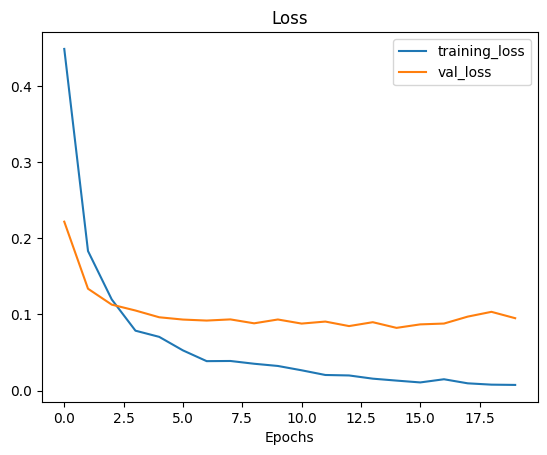

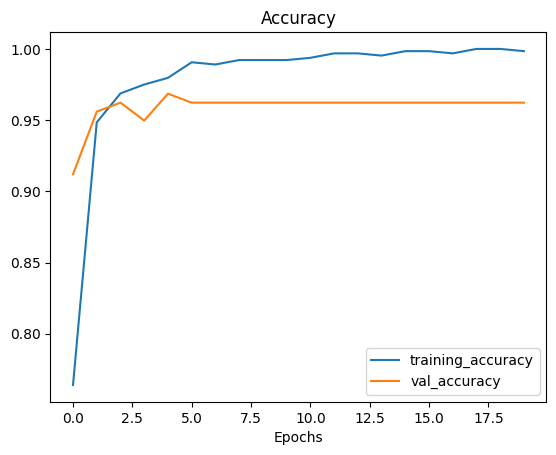

In [30]:
plot_loss_curves(history)

In [31]:

model.save('fire_classification_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f'The first 10 predictions: {pred[:10]}')

7/7 [==============================] - 4s 484ms/step
The first 10 predictions: ['fire_images', 'fire_images', 'non_fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images']


In [35]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.99      0.99      0.99       158
non_fire_images       0.98      0.95      0.96        42

       accuracy                           0.98       200
      macro avg       0.98      0.97      0.98       200
   weighted avg       0.98      0.98      0.98       200



In [36]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
fire_images,0.987421,0.993671,0.990536,158.000
non_fire_images,0.975610,0.952381,0.963855,42.000
accuracy,0.985000,0.985000,0.985000,0.985
macro avg,0.981516,0.973026,0.977196,200.000
weighted avg,0.984941,0.985000,0.984933,200.000


In [37]:
model.save('/content', save_format='tf')

In [40]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [42]:
img_path = '/content/fire_dataset/fire_images/fire.1.png'
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

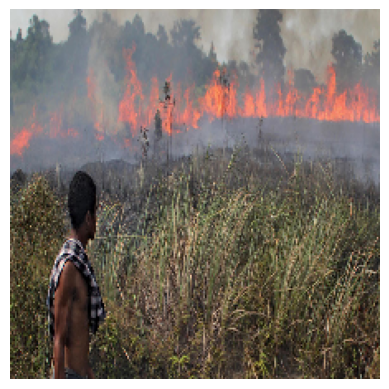

In [43]:
import matplotlib.pyplot as plt
plt.imshow(img_array[0])
plt.axis('off')
plt.show()

In [44]:

predictions = model.predict(img_array)

if predictions[0][0] > predictions[0][1]:
    print("Prediction: Fire")
else:
    print("Prediction: Non-Fire")


print(f"Confidence (Fire): {predictions[0][0]}")
print(f"Confidence (Non-Fire): {predictions[0][1]}")


1/1 [==============================] - 2s 2s/step
Prediction: Fire
Confidence (Fire): 0.9543891549110413
Confidence (Non-Fire): 0.045610833913087845
